# Adding a New Forecasting Model

This notebook provides a minimal example on how to add a new forecasting model to Merlion. We follow the instructions in [CONTRIBUTING.md](https://github.com/salesforce/Merlion/blob/main/CONTRIBUTING.md). We suggest you review this [notebook](1_ForecastFeatures.ipynb) explaining how to use a Merlion forecasting model before reading this one.

More specifically, let's implement a forecasting model whose forecast is just equal to the most recent observed value of the time series metric. For a more complete example, see our implementation of `Sarima` [here](https://github.com/salesforce/Merlion/blob/main/merlion/models/forecast/sarima.py).

## Model Config Class

The first step of creating a new model is defining an appropriate config class, which inherits from `ForecasterConfig`:

In [1]:
from merlion.models.forecast.base import ForecasterConfig

class RepeatRecentConfig(ForecasterConfig):
    def __init__(self, max_forecast_steps=None, **kwargs):
        super().__init__(max_forecast_steps=max_forecast_steps, **kwargs)


## Model Class

Next we define the model itself, which must inherit from the `ForecasterBase` base class and define all abstract methods. See the API docs for more details.

In [2]:
from collections import OrderedDict
from typing import List, Tuple

import numpy as np
import pandas as pd

from merlion.models.forecast.base import ForecasterBase
from merlion.utils.time_series import to_pd_datetime


class RepeatRecent(ForecasterBase):
    # The config class for RepeatRecent is RepeatRecentConfig, defined above
    config_class = RepeatRecentConfig
    
    @property
    def require_even_sampling(self):
        """
        Many forecasters assume the input time series is sampled evenly.
        That isn't a necessary assumption for this model, so override the property.
        """
        return False
        
    def __init__(self, config):
        """
        Sets the model config and any other local variables. Here, we initialize
        the most_recent_value to None.
        """
        super().__init__(config)
        self.most_recent_value = None
    
    
    def _train(self, train_data: pd.DataFrame, train_config=None) -> Tuple[pd.DataFrame, None]:        
        # "Train" the model. Here, we just gather the most recent values for each univariate.
        self.most_recent_value = [(k, v.values[-1]) for k, v in train_data.items()]
        
        # The model's "prediction" for the training data, is just the value from one step before.
        pred = np.concatenate((np.zeros((1, self.dim)), train_data.values[:-1]))
        train_forecast = pd.DataFrame(pred, index=train_data.index, columns=train_data.columns)
        
        # This model doesn't have any notion of error
        train_stderr = None
        
        # Return the train prediction & standard error
        return train_forecast, train_stderr
    
    def _forecast(self, time_stamps: List[int],
                  time_series_prev: pd.DataFrame = None,
                  return_prev=False
                ) -> Tuple[pd.DataFrame, None]:

        # Use time_series_prev's most recent value if time_series_prev is given.
        # Otherwise, use the most recent value stored from the training data
        if time_series_prev is not None:
            most_recent_value = [(k, v.values[-1]) for k, v in time_series_prev.items()]
        else:
            most_recent_value = self.most_recent_value
        
        # The forecast is just the most recent value repeated for every upcoming timestamp.
        # Note that we only care about the target_seq_index here.
        i = self.target_seq_index
        datetimes = to_pd_datetime(time_stamps)
        name, val = most_recent_value[i]
        forecast = pd.DataFrame([val] * len(datetimes), index=datetimes, columns=[name])
        
        # If desired, pre-pend "predicted" vals of the target_seq_index of time_series_prev.
        if return_prev and time_series_prev is not None:
            pred = np.concatenate(([0], time_series_prev.values[:-1, i]))
            prev_forecast = pd.DataFrame(pred, index=time_series_prev.index, columns=[name])
            forecast = pd.concat((prev_forecast, forecast))

        return forecast, None


## Running the Model: A Simple Example

Let's try running this model on some actual data! This next part assumes you've installed `ts_datasets`. We'll begin by getting a time series from the M4 dataset & visualizing it.

100%|██████████| 414/414 [00:00<00:00, 849.11it/s]


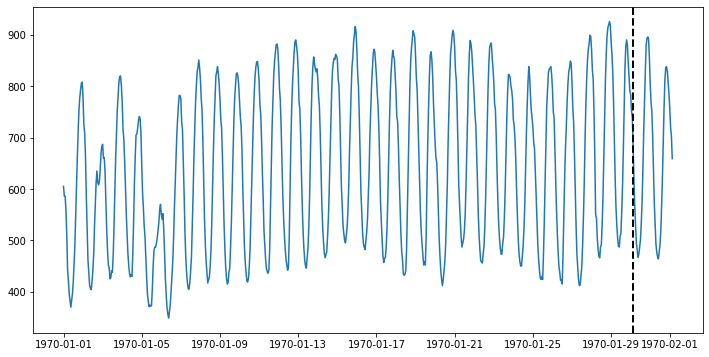

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

from merlion.utils import TimeSeries, UnivariateTimeSeries
from ts_datasets.forecast import M4

time_series, metadata = M4(subset="Hourly")[0]

# Visualize the full time series
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)

# Label the train/test split with a dashed line
ax.axvline(time_series[metadata["trainval"]].index[-1], ls="--", lw=2, c="k")

plt.show()

Now, we'll split the data into train & test splits, and run our forecasting model on it.

In [4]:
train_data = TimeSeries.from_pd(time_series[metadata["trainval"]])
test_data  = TimeSeries.from_pd(time_series[~metadata["trainval"]])

In [5]:
# Initialize a model & train it. The dataframe returned & printed
# below is the model's "forecast" on the training data. None is 
# the uncertainty estimate.
model = RepeatRecent(RepeatRecentConfig())
model.train(train_data=train_data)

(                        H1
 time                      
 1970-01-01 00:00:00    0.0
 1970-01-01 01:00:00  605.0
 1970-01-01 02:00:00  586.0
 1970-01-01 03:00:00  586.0
 1970-01-01 04:00:00  559.0
 ...                    ...
 1970-01-29 23:00:00  820.0
 1970-01-30 00:00:00  790.0
 1970-01-30 01:00:00  784.0
 1970-01-30 02:00:00  752.0
 1970-01-30 03:00:00  739.0
 
 [700 rows x 1 columns],
 None)

In [6]:
# Let's run our model on the test data now
forecast, err = model.forecast(test_data.to_pd().index)
print("Forecast")
print(forecast)
print()
print("Error")
print(err)

Forecast
                        H1
time                      
1970-01-30 04:00:00  684.0
1970-01-30 05:00:00  684.0
1970-01-30 06:00:00  684.0
1970-01-30 07:00:00  684.0
1970-01-30 08:00:00  684.0
1970-01-30 09:00:00  684.0
1970-01-30 10:00:00  684.0
1970-01-30 11:00:00  684.0
1970-01-30 12:00:00  684.0
1970-01-30 13:00:00  684.0
1970-01-30 14:00:00  684.0
1970-01-30 15:00:00  684.0
1970-01-30 16:00:00  684.0
1970-01-30 17:00:00  684.0
1970-01-30 18:00:00  684.0
1970-01-30 19:00:00  684.0
1970-01-30 20:00:00  684.0
1970-01-30 21:00:00  684.0
1970-01-30 22:00:00  684.0
1970-01-30 23:00:00  684.0
1970-01-31 00:00:00  684.0
1970-01-31 01:00:00  684.0
1970-01-31 02:00:00  684.0
1970-01-31 03:00:00  684.0
1970-01-31 04:00:00  684.0
1970-01-31 05:00:00  684.0
1970-01-31 06:00:00  684.0
1970-01-31 07:00:00  684.0
1970-01-31 08:00:00  684.0
1970-01-31 09:00:00  684.0
1970-01-31 10:00:00  684.0
1970-01-31 11:00:00  684.0
1970-01-31 12:00:00  684.0
1970-01-31 13:00:00  684.0
1970-01-31 14:00:00

## Visualization

Forecast w/ ground truth time series


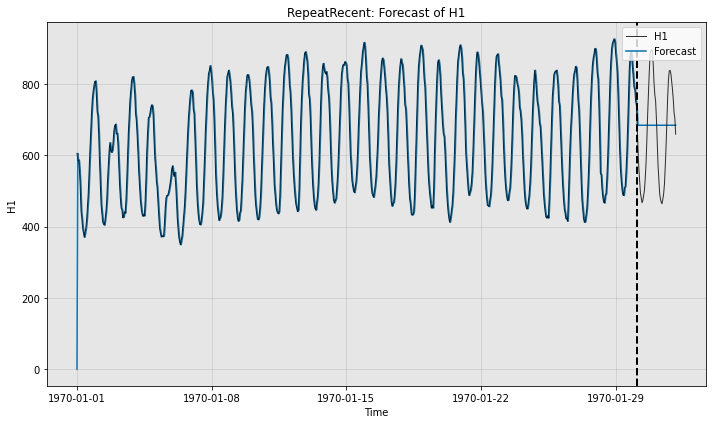


Forecast without ground truth time series


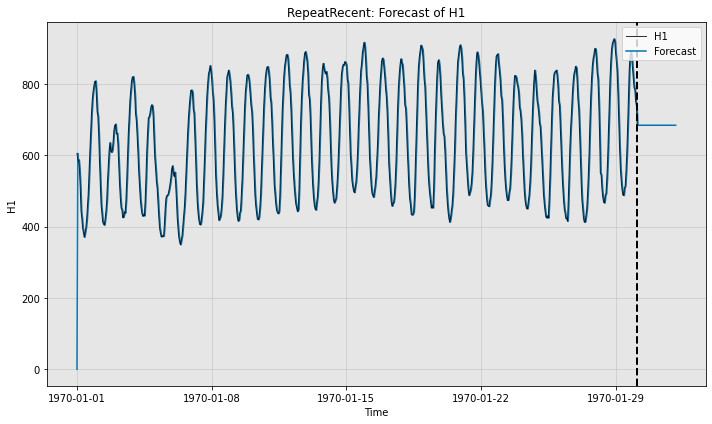

In [7]:
# Qualitatively, we can see what the forecaster is doing by plotting
print("Forecast w/ ground truth time series")
fig, ax = model.plot_forecast(time_series=test_data,
                              time_series_prev=train_data,
                              plot_time_series_prev=True)
plt.show()

print()
print("Forecast without ground truth time series")
fig, ax = model.plot_forecast(time_stamps=test_data.to_pd().index,
                              time_series_prev=train_data,
                              plot_time_series_prev=True)

## Quantitative Evaluation

You may quantitatively evaluate your model as well. Here, we compute the sMAPE (symmetric Mean Average Percent Error) of the model's forecast vs. the true data. For ground truth $y \in \mathbb{R}^T$ and prediction $\hat{y} \in \mathbb{R}^T$, the sMAPE is computed as

$$
\mathrm{sMAPE}(y, \hat{y}) = \frac{200}{T} \sum_{t = 1}^{T} \frac{\lvert \hat{y}_t - y_t \rvert}{\lvert\hat{y}_t\rvert + \lvert y_t \rvert}
$$

In [8]:
from merlion.evaluate.forecast import ForecastMetric
smape = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast)
print(f"sMAPE = {smape:.3f}")

sMAPE = 20.166


## Defining a Forecaster-Based Anomaly Detector

It is quite straightforward to adapt a forecasting model into an anomaly detection model. You just need to create a new file in the appropriate [directory](https://github.com/salesforce/Merlion/blob/main/merlion/models/anomaly/forecast_based) and define class stubs with some basic headers. Multiple inheritance with `ForecastingDetectorBase` takes care of most of the heavy lifting.

The anomaly score returned by any forecasting-based anomaly detector is based on the residual between the predicted and true time series values. 

In [9]:
from merlion.evaluate.anomaly import TSADMetric
from merlion.models.anomaly.forecast_based.base import ForecastingDetectorBase
from merlion.models.anomaly.base import DetectorConfig
from merlion.post_process.threshold import AggregateAlarms
from merlion.transform.normalize import MeanVarNormalize


# Define a config class which inherits from RepeatRecentConfig and DetectorConfig, in that order
class RepeatRecentDetectorConfig(RepeatRecentConfig, DetectorConfig):
    # Set a default anomaly score post-processing rule
    _default_post_rule = AggregateAlarms(alm_threshold=3.0)
    
    # The default data pre-processing transform is mean-variance normalization,
    # so that anomaly scores are roughly aligned with z-scores
    _default_transform = MeanVarNormalize()

# Define a model class which inherits from ForecastingDetectorBase and RepeatRecent
# in that order
class RepeatRecentDetector(ForecastingDetectorBase, RepeatRecent):
    # All we need to do is set the config class
    config_class = RepeatRecentDetectorConfig

In [10]:
# Train the anomaly detection variant
model2 = RepeatRecentDetector(RepeatRecentDetectorConfig())
model2.train(train_data)

                     anom_score
time                           
1970-01-01 00:00:00   -0.212986
1970-01-01 01:00:00   -0.120839
1970-01-01 02:00:00    0.000000
1970-01-01 03:00:00   -0.171719
1970-01-01 04:00:00   -0.305278
...                         ...
1970-01-29 23:00:00   -0.190799
1970-01-30 00:00:00   -0.038160
1970-01-30 01:00:00   -0.203519
1970-01-30 02:00:00   -0.082679
1970-01-30 03:00:00   -0.349798

[700 rows x 1 columns]

In [11]:
# Obtain the anomaly detection variant's predictions on the test data
model2.get_anomaly_score(test_data)

                     anom_score
time                           
1970-01-30 04:00:00   -0.413397
1970-01-30 05:00:00   -0.756835
1970-01-30 06:00:00   -0.966714
1970-01-30 07:00:00   -1.202032
1970-01-30 08:00:00   -1.291072
1970-01-30 09:00:00   -1.380111
1970-01-30 10:00:00   -1.341952
1970-01-30 11:00:00   -1.246552
1970-01-30 12:00:00   -1.163873
1970-01-30 13:00:00   -0.953994
1970-01-30 14:00:00   -0.686876
1970-01-30 15:00:00   -0.286198
1970-01-30 16:00:00    0.178079
1970-01-30 17:00:00    0.559676
1970-01-30 18:00:00    0.928554
1970-01-30 19:00:00    1.246552
1970-01-30 20:00:00    1.329232
1970-01-30 21:00:00    1.348311
1970-01-30 22:00:00    1.316512
1970-01-30 23:00:00    1.081193
1970-01-31 00:00:00    0.756835
1970-01-31 01:00:00    0.540597
1970-01-31 02:00:00    0.426117
1970-01-31 03:00:00    0.108119
1970-01-31 04:00:00   -0.311638
1970-01-31 05:00:00   -0.712316
1970-01-31 06:00:00   -0.966714
1970-01-31 07:00:00   -1.214752
1970-01-31 08:00:00   -1.316512
1970-01-

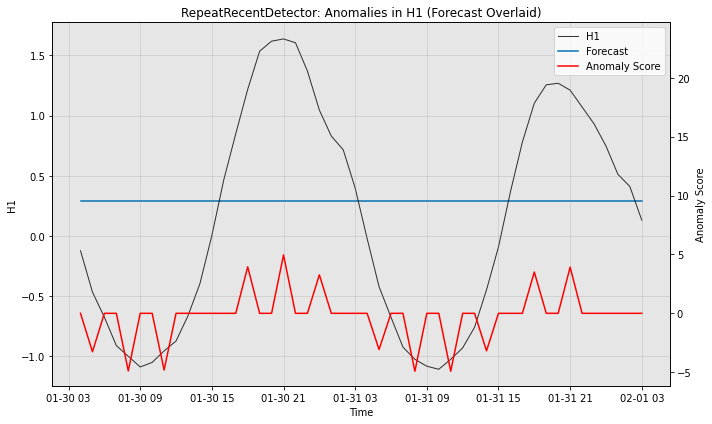

In [12]:
# Visualize the anomaly detection variant's performance, with filtered anomaly scores
fig, ax = model2.plot_anomaly(test_data, time_series_prev=train_data,
                              filter_scores=True, plot_time_series_prev=False,
                              plot_forecast=True)